# Szegedy’s quantum walk with queries (Santos, 2016)

Implementation of the algorithm described in [this paper](https://link.springer.com/article/10.1007/s11128-016-1427-4).

## Import libraries

In [289]:
import pennylane as qml
import pennylane.numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [158]:
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=3, suppress=True)
qml.__version__

'0.41.1'

## 2 Szegedy's Quatum Walk

In [526]:
N = 10 # dimension of the graph
n = int(np.ceil(np.log2(N))) # dimension of the associated Hilbert space
print(f"N = {N}")
print(f"n = {n}")

N = 10
n = 4


### Stochastic matrices

![Complete graph with m=5, n=1](complete_graph_m1.PNG "Complete graph with m=5, n=1")

#### $P'$

In [538]:
m = 9 # marked state
absorbing = True # absorbing QRW for marked states
# transition matrix
P = block_diag(1/(N-1) * (np.ones(N) - np.eye(N)), np.eye(2**n-N))
# absorbing RW
if (absorbing):
    for i in range(N):
        P[m-1, i] = 0
    P[m-1, m-1] = 1

print(P)
print(P.shape)
# print(P*P.T)

[[0.    0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.    0.
  0.    0.    0.    0.   ]
 [0.111 0.    0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.    0.
  0.    0.    0.    0.   ]
 [0.111 0.111 0.    0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.    0.
  0.    0.    0.    0.   ]
 [0.111 0.111 0.111 0.    0.111 0.111 0.111 0.111 0.111 0.111 0.    0.
  0.    0.    0.    0.   ]
 [0.111 0.111 0.111 0.111 0.    0.111 0.111 0.111 0.111 0.111 0.    0.
  0.    0.    0.    0.   ]
 [0.111 0.111 0.111 0.111 0.111 0.    0.111 0.111 0.111 0.111 0.    0.
  0.    0.    0.    0.   ]
 [0.111 0.111 0.111 0.111 0.111 0.111 0.    0.111 0.111 0.111 0.    0.
  0.    0.    0.    0.   ]
 [0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.    0.111 0.111 0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.111 0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    

#### $R_A$

In [539]:
# initial state of the quantum walk
RA = np.zeros((2**(2*n), 2**(2*n)))

for x in range(2**n):
    phi = np.zeros((2**(2*n), 1))
    ket_x = np.zeros((2**n, 1))
    ket_x[x] = 1
    for y in range(2**n):
        ket_y = np.zeros((2**n, 1))
        ket_y[y] = np.sqrt(P[x][y])
        phi += np.kron(ket_x, ket_y) # x⊗y
    # print(f"x={x}")
    # print(np.sum(phi**2)) # norm-square: should be one for a "valid" quantum state
    # print(phi.T)   
    RA += np.dot(phi, phi.T)    
RA = 2 * RA - np.eye(2**(2*n))
print(RA.shape)
# print(RA)
# print('\n')
# print(np.dot(RA, RA.T))
print(r'Is $R_A$ unitary (left)?', np.all(np.allclose(np.dot(RA, RA.T), np.eye(2**(2*n)))))
# print(np.dot(RA.T, RA))
print(r'Is $R_A$ unitary (right)?', np.all(np.allclose(np.dot(RA.T, RA), np.eye(2**(2*n)))))

(256, 256)
Is $R_A$ unitary (left)? True
Is $R_A$ unitary (right)? True


#### $R_B$

In [540]:
RB = np.zeros((2**(2*n), 2**(2*n)))

for y in range(2**n):
    psi = np.zeros((2**(2*n), 1))
    ket_y = np.zeros((2**n, 1))
    ket_y[y] = 1
    for x in range(2**n):
        ket_x = np.zeros((2**n, 1))
        ket_x[x] = np.sqrt(P[y][x])
        psi += np.kron(ket_x, ket_y) # y⊗x
    RB += np.dot(psi, psi.T)    
RB = 2 * RB - np.eye(2**(2*n))
print(RB.shape)
# print(RB)
# print(np.dot(RB, RB.T))
print('Is RB unitary (left)?', np.all(np.allclose(np.dot(RB, RB.T), np.eye(2**(2*n)))))
print('Is RB unitary (right)?', np.all(np.allclose(np.dot(RB.T, RB), np.eye(2**(2*n)))))

(256, 256)
Is RB unitary (left)? True
Is RB unitary (right)? True


### Searching

In [541]:
# initial state
psi = np.zeros((2**(2*n)))
for x in range(N):
    ket_x = np.zeros((2**n))
    ket_x[x] = 1
    for y in range(N):
        ket_y = np.zeros((2**n))
        ket_y[y] += np.sqrt(P[x][y])
        psi += np.kron(ket_x, ket_y)    
psi /= np.sqrt(N)
# print(psi)
print("Is the statevector valid?", qml.math.isclose(qml.math.norm(np.sum(psi**2)), 1))

Is the statevector valid? True


In [542]:
Up = np.dot(RB, RA) # marked walk operator
np.allclose(Up, Up.T) 

False

### Quantum circuit

In [543]:
num_qubits = 2*n
# Create a device for simulation
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def circuit(steps):
    qml.StatePrep(psi, wires=range(num_qubits))
    # [qml.Hadamard(i) for i in range(num_qubits)]
    for _ in range(steps):
        # Apply the unitary matrix
        qml.QubitUnitary(Up, wires=range(num_qubits), id=r"$U_p$")
    # Measure all qubits
    return qml.state()

(<Figure size 700x900 with 1 Axes>, <Axes: >)

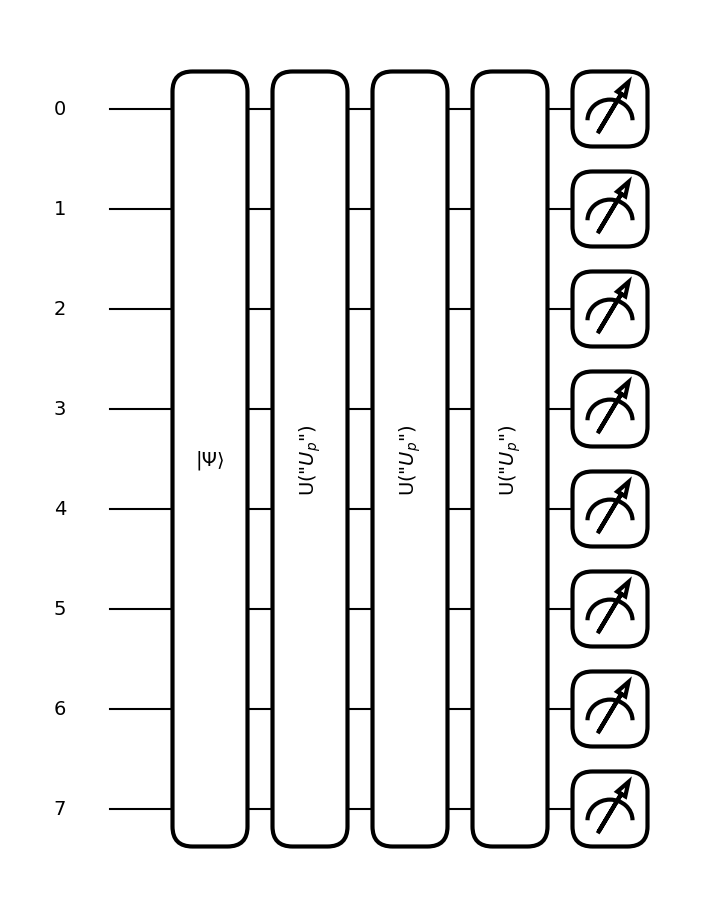

In [544]:
# draw a sample quantum circuit
qml.draw_mpl(circuit)(3)

In [576]:
# data arrays
m_x = []
m_y = []
max_data = []
m_data = []

# Execute the circuit
print("Steps\tMax\t\tsum_pm\tmax_index\tx\ty\tx==m")
print("--------------------------------------------------------------")
steps = 4*N
for k in range(1, steps+1):
    state_vector = np.abs(circuit(k)**2)
    # Plot the quantum circuit
    # fig, ax = qml.draw_mpl(circuit)(steps)
    # ax.set_title(f"k={steps}", fontsize=20)
    sum_pm = np.sum(state_vector[(m-1)*2**n:(m)*2**n])
    for i in range(N):
        if i==m-1:
            continue
        sum_pm += state_vector[2**n*i+(m-1)] 
    m_data.append(sum_pm)
    max_prob = np.max(state_vector)
    max_data.append(max_prob) 
    max_index = qml.math.argmax(state_vector)
    print(f"{k}\t{max_prob:.5f}\t\t{sum_pm:.3f}\t{max_index}\t\t{max_index//2**n}\t{max_index%2**n}\t{max_index//2**n==m-1}")
    if max_index//2**n==m-1:
        m_x.append(k)
        m_y.append(max_prob)

Steps	Max		sum_pm	max_index	x	y	x==m
--------------------------------------------------------------
1	0.10000		0.516	136		8	8	True
2	0.10000		0.992	136		8	8	True
3	0.10000		0.365	136		8	8	True
4	0.10000		0.299	136		8	8	True
5	0.10000		0.969	136		8	8	True
6	0.10000		0.598	136		8	8	True
7	0.10000		0.170	136		8	8	True
8	0.10000		0.821	136		8	8	True
9	0.10000		0.824	136		8	8	True
10	0.10000		0.171	136		8	8	True
11	0.10000		0.595	136		8	8	True
12	0.10000		0.971	136		8	8	True
13	0.10000		0.301	136		8	8	True
14	0.10000		0.362	136		8	8	True
15	0.10000		0.992	136		8	8	True
16	0.10000		0.519	136		8	8	True
17	0.10000		0.199	136		8	8	True
18	0.10000		0.881	136		8	8	True
19	0.10000		0.756	136		8	8	True
20	0.10000		0.155	136		8	8	True
21	0.10000		0.672	136		8	8	True
22	0.10000		0.935	136		8	8	True
23	0.10000		0.246	136		8	8	True
24	0.10000		0.434	136		8	8	True
25	0.10000		1.000	136		8	8	True
26	0.10000		0.443	136		8	8	True
27	0.10000		0.240	136		8	8	True
28	0.10000		0.930	136		8	8	True
29	0.10000		0

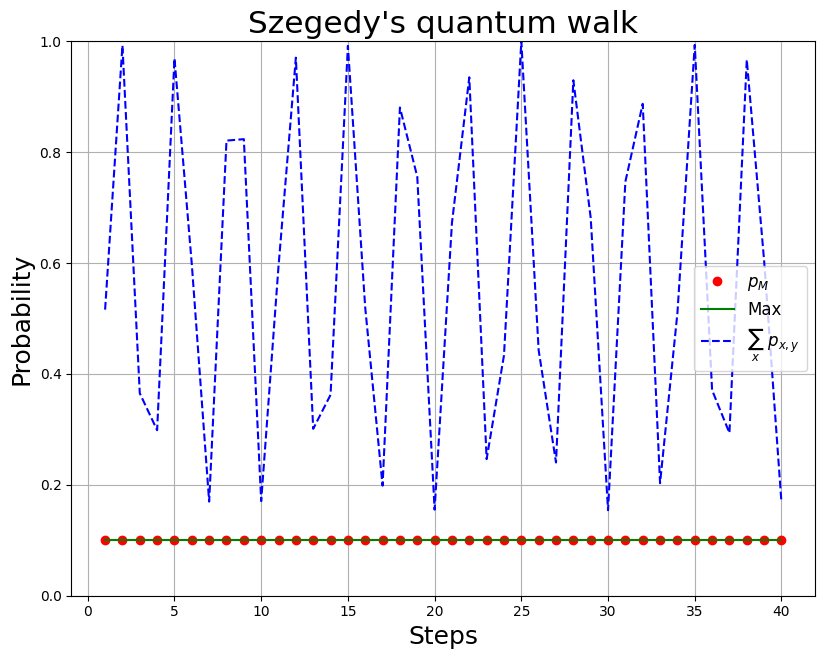

In [577]:
scale_factor = 1.5
default_figsize = plt.rcParams["figure.figsize"]
scaled_figsize = (default_figsize[0] * scale_factor, default_figsize[1] * scale_factor)

plt.figure(figsize=scaled_figsize)
plt.plot(m_x, m_y, "ro", label=r"$p_M$")
plt.plot(range(1, steps+1), max_data, 'g', label=r"Max")
plt.plot(range(1, steps+1), m_data, "b--", label=r"$\sum_x~p_{x,y}$")
plt.legend(fontsize=12)
plt.title("Szegedy's quantum walk", fontsize=15*scale_factor)
plt.xlabel("Steps", fontsize=12*scale_factor)
plt.ylabel("Probability", fontsize=12*scale_factor)
plt.ylim((0, 1))
plt.grid()
plt.show()

In [578]:
np.argmax(m_data)

np.int64(24)

In [579]:
np.max(m_data)

np.float64(0.9999717646181921)